In [1]:
from sklearn.neural_network import MLPRegressor

from scripts.shared_utilities import *

2024-05-29 21:27:42.566105: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-29 21:27:42.569993: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-29 21:27:42.626108: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-29 21:27:43.519328: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
model = ComposedKerasSklearnModel(Path("../models/modello-passi-CNN.keras"), Ridge())

In [3]:
data = DateStepSleepData()

In [4]:
utils = Utilities(model, data)

In [5]:
utils.train_model()

2024-05-29 21:27:47.511816: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 153657600 exceeds 10% of free system memory.
2024-05-29 21:27:47.563587: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 160060000 exceeds 10% of free system memory.
2024-05-29 21:27:47.594111: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 160060000 exceeds 10% of free system memory.
2024-05-29 21:27:47.688904: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 153657600 exceeds 10% of free system memory.
2024-05-29 21:27:47.720871: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 153657600 exceeds 10% of free system memory.


In [6]:
utils.evaluate_model()

-0.03014620777862298

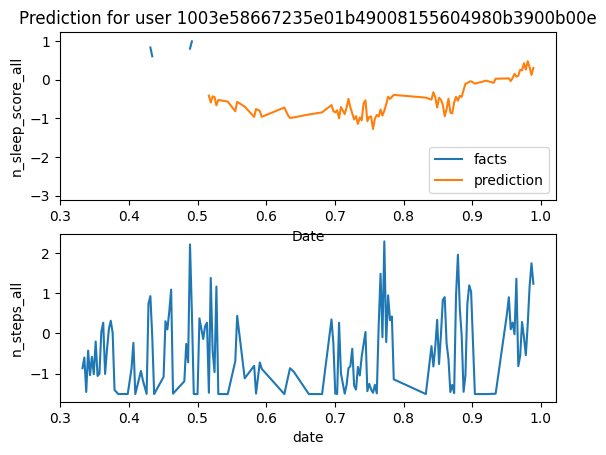

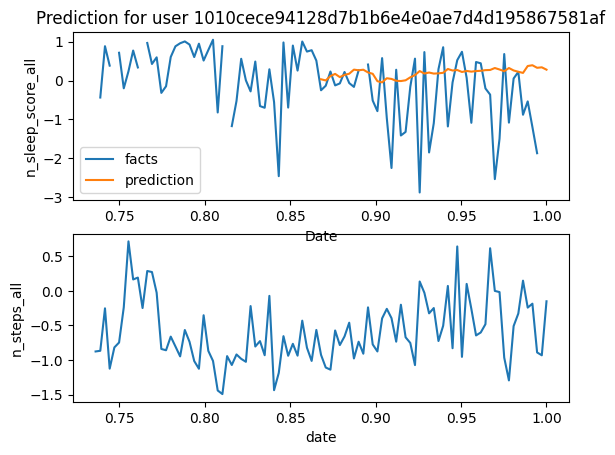

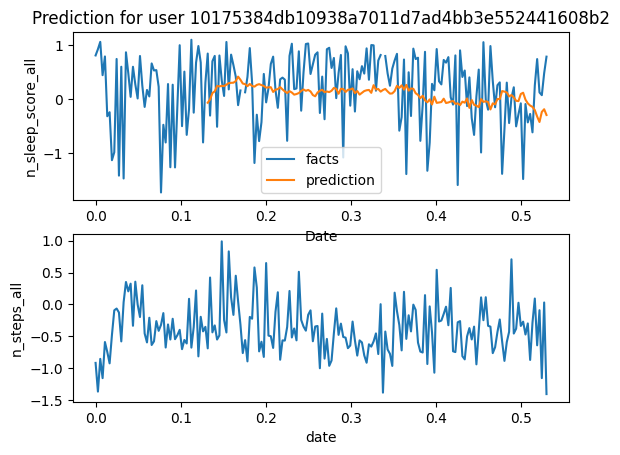

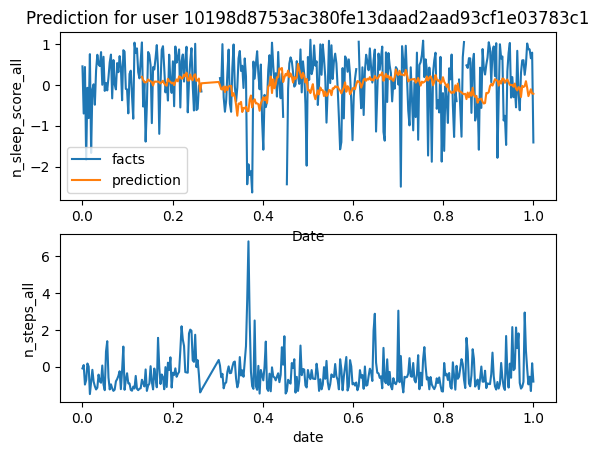

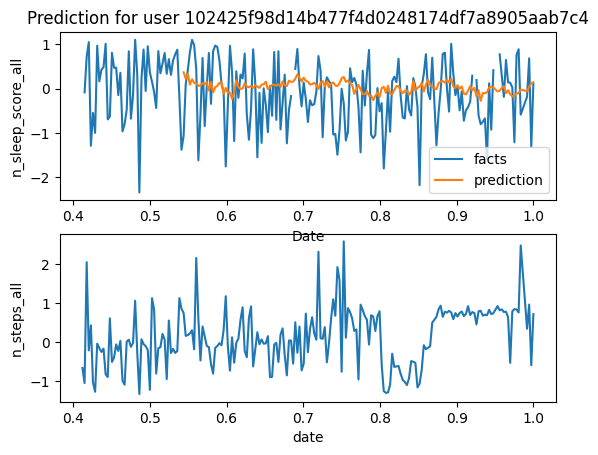

In [7]:
DateSleepStepPredictionVisualization(model, data).visualize()